In [ ]:
from datasets import load_dataset
import pandas as pd

# Download dataset
dataset = load_dataset("tweet_eval", "sentiment")

# Convert to DataFrame
train_df = pd.DataFrame(dataset["train"])
val_df   = pd.DataFrame(dataset["validation"])
test_df  = pd.DataFrame(dataset["test"])

# Rename text column
for df in [train_df, val_df, test_df]:
    df.rename(columns={"text": "tweet"}, inplace=True)

# Combine all splits into one CSV
full_df = pd.concat(
    [
        train_df.assign(split="train"),
        val_df.assign(split="validation"),
        test_df.assign(split="test")
    ],
    ignore_index=True
)

# Save CSV file
full_df.to_csv("tweet_eval_sentiment_full.csv", index=False)

print("CSV file created successfully")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

CSV file created successfully


In [ ]:
from google.colab import files
files.download("tweet_eval_sentiment_full.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GPU info:
Wed Dec 31 12:30:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------------------------------

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2562833159.py:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.669800,0.644403,0.716500
2,0.474500,0.620921,0.735500
3,0.287400,0.776228,0.729000
4,0.160800,0.994914,0.727000
5,0.105100,1.266059,0.717500
6,0.075200,1.612889,0.718000
7,0.054200,1.689615,0.725500
8,0.034200,1.946821,0.726000
9,0.023800,1.950604,0.733000
10,0.011700,2.071412,0.733000



Validation Accuracy per Epoch:
Epoch 1: 71.65%
Epoch 2: 73.55%
Epoch 3: 72.90%
Epoch 4: 72.70%
Epoch 5: 71.75%
Epoch 6: 71.80%
Epoch 7: 72.55%
Epoch 8: 72.60%
Epoch 9: 73.30%
Epoch 10: 73.30%


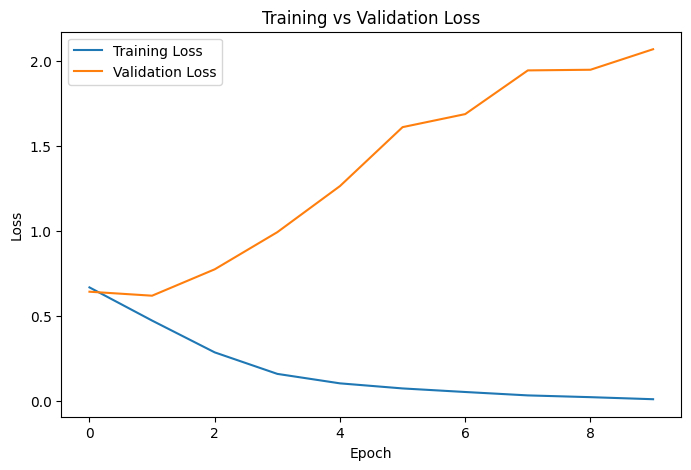

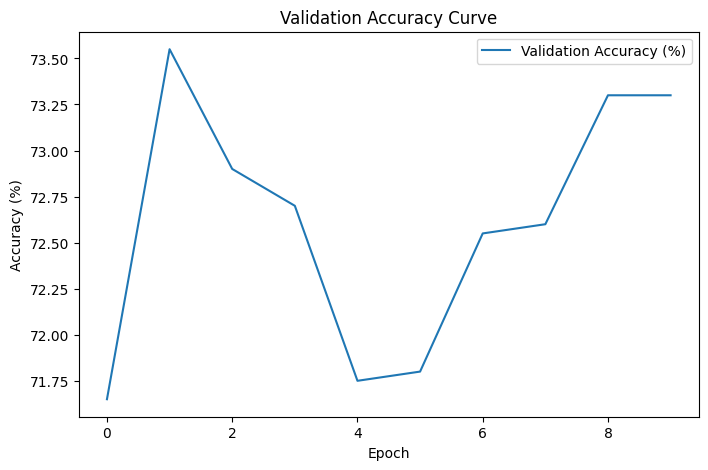

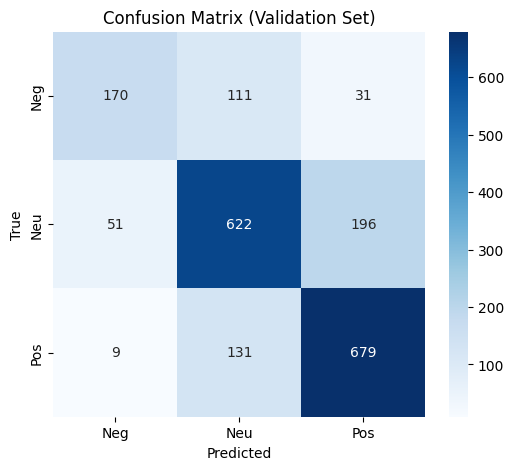


Final Validation Accuracy: 73.55000000000001


In [ ]:
# ============================================================
# DistilBERT | TweetEval Sentiment (3-class)
# 10 Epochs | Accuracy %, Loss Curves, Confusion Matrix
# ============================================================

!pip install -q transformers datasets accelerate scikit-learn torch matplotlib seaborn

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, confusion_matrix

# -------------------------
# GPU check
# -------------------------
print("GPU info:")
!nvidia-smi

# -------------------------
# Load TweetEval Sentiment dataset
# -------------------------
dataset = load_dataset("tweet_eval", "sentiment")

train_ds = dataset["train"]
val_ds   = dataset["validation"]
test_ds  = dataset["test"]

print("Dataset sizes:")
print("Train:", len(train_ds))
print("Validation:", len(val_ds))
print("Test:", len(test_ds))

# -------------------------
# Tokenizer
# -------------------------
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
val_ds   = val_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# -------------------------
# Metrics
# -------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# -------------------------
# Model
# -------------------------
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

# -------------------------
# Training arguments
# -------------------------
training_args = TrainingArguments(
    output_dir="/content/distilbert_tweeteval",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    logging_strategy="epoch",
    report_to="none"
)

# -------------------------
# Trainer
# -------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# -------------------------
# Train
# -------------------------
trainer.train()

# -------------------------
# Extract training history
# -------------------------
train_loss = []
val_loss = []
val_acc = []

for log in trainer.state.log_history:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        val_acc.append(log["eval_accuracy"] * 100)

# -------------------------
# Print accuracy per epoch
# -------------------------
print("\nValidation Accuracy per Epoch:")
for i, acc in enumerate(val_acc, start=1):
    print(f"Epoch {i}: {acc:.2f}%")

# -------------------------
# Loss curves
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# -------------------------
# Accuracy curve
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(val_acc, label="Validation Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.show()

# -------------------------
# Confusion matrix (on validation set)
# -------------------------
pred_output = trainer.predict(val_ds)
preds = np.argmax(pred_output.predictions, axis=1)
true = pred_output.label_ids

cm = confusion_matrix(true, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

print("\nFinal Validation Accuracy:",
      accuracy_score(true, preds) * 100)

In [ ]:
# ============================================================
# BERT-base | TweetEval Sentiment (3-class)
# Emoji Removed | Max 10 Epochs | Full Evaluation
# ============================================================

!pip install -q transformers datasets accelerate scikit-learn torch matplotlib seaborn emoji

import re
import emoji
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    set_seed
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -------------------------
# Load Dataset
# -------------------------
dataset = load_dataset("tweet_eval", "sentiment")
train_ds = dataset["train"]
val_ds   = dataset["validation"]

# -------------------------
# Emoji + Noise Removal
# -------------------------
def clean_text(text):
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

train_ds = train_ds.map(lambda x: {"text": clean_text(x["text"])})
val_ds   = val_ds.map(lambda x: {"text": clean_text(x["text"])})

# -------------------------
# Tokenization
# -------------------------
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
val_ds   = val_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# -------------------------
# Class Weights
# -------------------------
labels = np.array(train_ds["labels"]) # Convert Column object to numpy array
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# -------------------------
# Custom Trainer (Weighted Loss)
# -------------------------
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fn = torch.nn.CrossEntropyLoss(
            weight=class_weights.to(logits.device)
        )
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# -------------------------
# Metrics
# -------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

# -------------------------
# Model
# -------------------------
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)

# -------------------------
# Training Arguments (Max 10 Epochs)
# -------------------------
training_args = TrainingArguments(
    output_dir="./bert_tweeteval",
    overwrite_output_dir=True,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_strategy="epoch",
    fp16=True,
    report_to="none"
)

# -------------------------
# Trainer
# -------------------------
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# -------------------------
# Train
# -------------------------
trainer.train()

# ============================================================
# POST-TRAINING EVALUATION
# ============================================================

# Predictions
val_out = trainer.predict(val_ds)
y_pred = np.argmax(val_out.predictions, axis=1)
y_true = val_out.label_ids

# Classification Report
print("\nClassification Report (Validation):\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=["Negative", "Neutral", "Positive"],
    digits=4
))

# Final Accuracy
final_val_acc = accuracy_score(y_true, y_pred) * 100
print(f"\nFinal Validation Accuracy: {final_val_acc:.2f}%")

# -------------------------
# Confusion Matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Negative","Neutral","Positive"],
    yticklabels=["Negative","Neutral","Positive"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set")
plt.show()

# -------------------------
# Curves
# -------------------------
train_loss, val_loss, val_acc = [], [], []

for log in trainer.state.log_history:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        val_acc.append(log["eval_accuracy"] * 100)

epochs = range(1, len(val_acc) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss[:len(epochs)], label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1729904774.py:150: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.771400,0.632871,0.699500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.143900,1.395406,0.721500



📊 Classification Report (Validation):

              precision    recall  f1-score   support

    Negative     0.6214    0.6154    0.6184       312
     Neutral     0.6958    0.7054    0.7006       869
    Positive     0.7778    0.7692    0.7735       819

    accuracy                         0.7175      2000
   macro avg     0.6983    0.6967    0.6975      2000
weighted avg     0.7178    0.7175    0.7176      2000


✅ Final Training Accuracy   : 97.40%
✅ Final Validation Accuracy : 71.75%


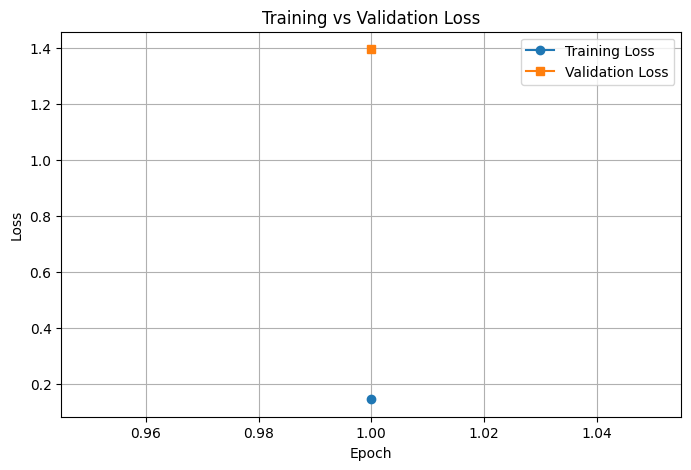

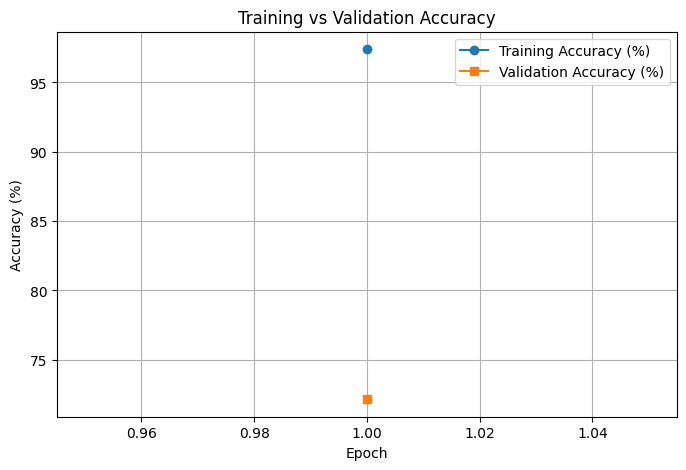

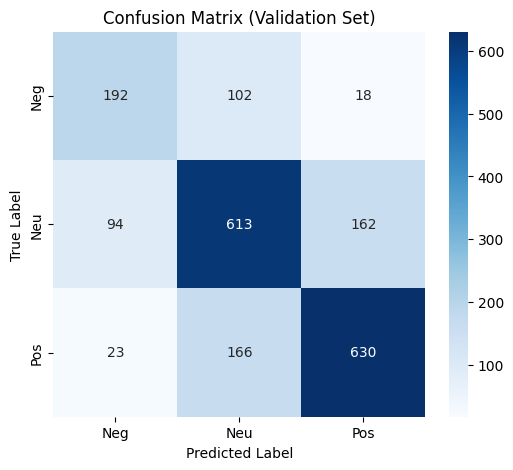

In [ ]:
# ============================================================
# FINAL POST-TRAINING ANALYSIS (FIXED)
# Loss Curves | Accuracy Curves | Confusion Matrix
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -------------------------
# 1️⃣ Predictions (Validation)
# -------------------------
val_out = trainer.predict(val_ds)
y_pred = np.argmax(val_out.predictions, axis=1)
y_true = val_out.label_ids

print("\n📊 Classification Report (Validation):\n")
print(classification_report(
    y_true, y_pred,
    target_names=["Negative", "Neutral", "Positive"],
    digits=4
))

# -------------------------
# 2️⃣ Final Accuracies
# -------------------------
train_out = trainer.predict(train_ds)
train_preds = np.argmax(train_out.predictions, axis=1)

train_acc = accuracy_score(train_out.label_ids, train_preds) * 100
val_acc_final = accuracy_score(y_true, y_pred) * 100

print(f"\n✅ Final Training Accuracy   : {train_acc:.2f}%")
print(f"✅ Final Validation Accuracy : {val_acc_final:.2f}%")

# -------------------------
# 3️⃣ Extract Epoch-wise Loss & Accuracy (CORRECT)
# -------------------------
train_loss, val_loss, val_acc = [], [], []

for log in trainer.state.log_history:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        val_acc.append(log["eval_accuracy"] * 100)

epochs = range(1, len(val_loss) + 1)

# -------------------------
# 4️⃣ Training vs Validation Loss Curve
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss[:len(epochs)], marker="o", label="Training Loss")
plt.plot(epochs, val_loss, marker="s", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# 5️⃣ Training vs Validation Accuracy Curve
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, [train_acc]*len(epochs), marker="o", label="Training Accuracy (%)")
plt.plot(epochs, val_acc, marker="s", label="Validation Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# 6️⃣ Confusion Matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Neg","Neu","Pos"],
    yticklabels=["Neg","Neu","Pos"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


Transformers version check
4.57.3
GPU info:
Thu Jan  1 11:30:50 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2316368583.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.732600,0.658061,0.727500
2,0.593200,0.676628,0.707000
3,0.489500,0.736507,0.723000
4,0.388900,0.758508,0.732000
5,0.319500,1.002974,0.728000
6,0.264500,1.073997,0.722000
7,0.224200,1.150698,0.721500
8,0.173900,1.293755,0.732000
9,0.138100,1.445831,0.723000
10,0.109900,1.497431,0.730500



Validation Accuracy per Epoch:
Epoch 1: 72.75%
Epoch 2: 70.70%
Epoch 3: 72.30%
Epoch 4: 73.20%
Epoch 5: 72.80%
Epoch 6: 72.20%
Epoch 7: 72.15%
Epoch 8: 73.20%
Epoch 9: 72.30%
Epoch 10: 73.05%


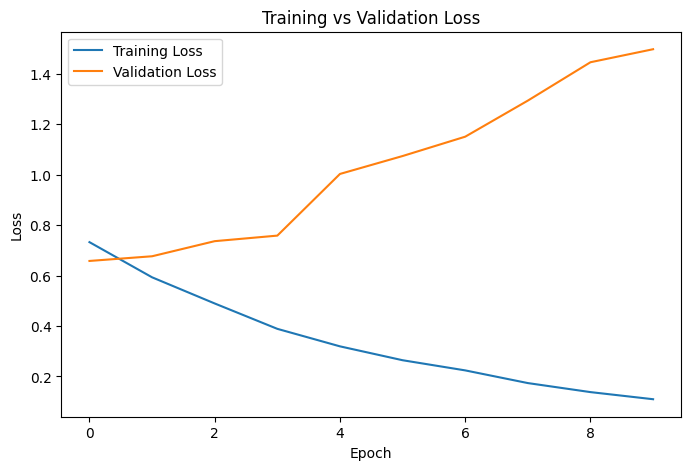

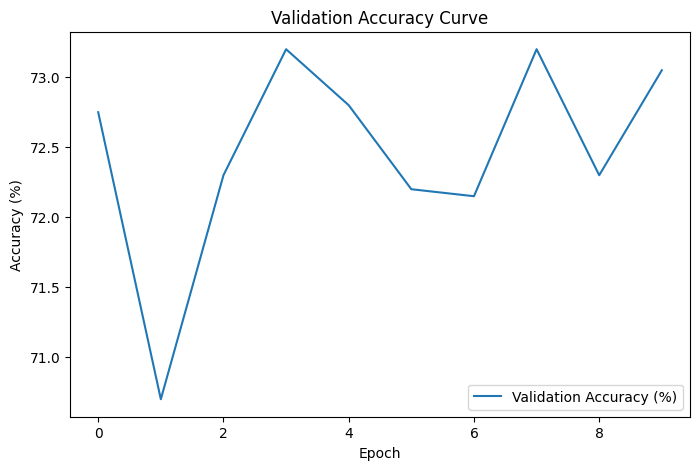

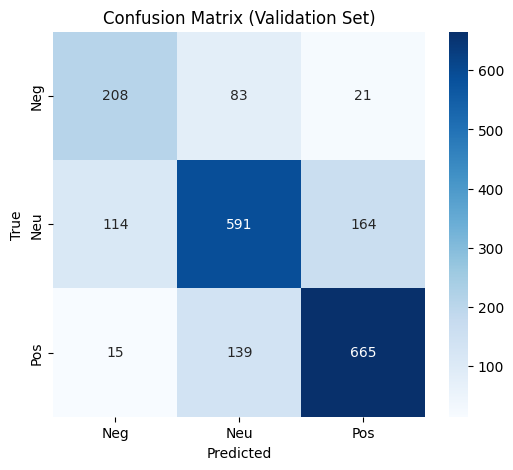


Final Validation Accuracy: 73.2


In [ ]:
# ============================================================
# RoBERTa-base | TweetEval Sentiment (3-class)
# 10 Epochs | Accuracy %, Loss Curves, Confusion Matrix
# ============================================================

!pip install -q --upgrade transformers datasets accelerate scikit-learn torch matplotlib seaborn

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, confusion_matrix

print("Transformers version check")
import transformers
print(transformers.__version__)

# -------------------------
# GPU check
# -------------------------
print("GPU info:")
!nvidia-smi

# -------------------------
# Load TweetEval Sentiment dataset
# -------------------------
dataset = load_dataset("tweet_eval", "sentiment")

train_ds = dataset["train"]
val_ds   = dataset["validation"]

# -------------------------
# Tokenizer
# -------------------------
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
val_ds   = val_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# -------------------------
# Metrics
# -------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

# -------------------------
# Model
# -------------------------
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=3
)

# -------------------------
# Training arguments (FIXED)
# -------------------------
training_args = TrainingArguments(
    output_dir="/content/roberta_base_tweeteval",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    logging_strategy="epoch",
    report_to="none"
)

# -------------------------
# Trainer
# -------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# -------------------------
# Train
# -------------------------
trainer.train()

# -------------------------
# Extract history
# -------------------------
train_loss = []
val_loss = []
val_acc = []

for log in trainer.state.log_history:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        val_acc.append(log["eval_accuracy"] * 100)

print("\nValidation Accuracy per Epoch:")
for i, acc in enumerate(val_acc, start=1):
    print(f"Epoch {i}: {acc:.2f}%")

# -------------------------
# Loss curves
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# -------------------------
# Accuracy curve
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(val_acc, label="Validation Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.show()

# -------------------------
# Confusion matrix
# -------------------------
pred_output = trainer.predict(val_ds)
preds = np.argmax(pred_output.predictions, axis=1)
true = pred_output.label_ids

cm = confusion_matrix(true, preds)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Neg", "Neu", "Pos"],
    yticklabels=["Neg", "Neu", "Pos"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

print("\nFinal Validation Accuracy:",
      accuracy_score(true, preds) * 100)